## Google Geocoding Validation
### - Run 1: address
### - Run 2: address + county
### - Run 3: address + municipality + county

In [1]:
# imports

import pandas as pd
import googlemaps
from math import radians, cos, sin, asin, sqrt
import os
from dotenv import load_dotenv
import time

# Load API key apo .env file
load_dotenv()
GOOGLE_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

if not GOOGLE_API_KEY:
    print("ERROR: GOOGLE_MAPS_API_KEY not found in .env file")
else:
    print("API Key loaded successfully!")

# Google Maps client
gmaps = googlemaps.Client(key=GOOGLE_API_KEY)

# Input file
INPUT_FILE = "/Users/geo/Desktop/fuelstation-detection-thesis/data/ALL_cleaned.xlsx"

API Key loaded successfully!


In [2]:
# Diavasma Excel
df = pd.read_excel(INPUT_FILE, sheet_name='Cleaned')

print(f"Loaded {len(df)} fuel stations")
print(f"Columns: {list(df.columns)}")
df.head()

Loaded 1026 fuel stations
Columns: ['gasStationID', 'gasStationAddress', 'gasStationLat', 'gasStationLong', 'locationType', 'ddName', 'municipalityName', 'countyName', 'cluster']


,gasStationID,gasStationAddress,gasStationLat,gasStationLong,locationType,ddName,municipalityName,countyName,cluster
0,11078,6o χιλ. ΕΟ Αγρινιου Ιωαννινων,38.670417,21.346708,ROOFTOP,Δ.Δ.Νεάπολης,ΔΗΜΟΣ ΝΕΑΠΟΛΗΣ,ΑΙΤΩΛΟΑΚΑΡΝΑΝΙΑΣ,0
1,28,"2,5 ΧΛΜ Ε.Ο. ΙΩΑΝΝΙΝΩΝ ΑΝΤΙΡΡΙΟΥ",38.337761,21.745611,ROOFTOP,Δ.Δ.Αντιρρίου,ΔΗΜΟΣ ΑΝΤΙΡΡΙΟΥ,ΑΙΤΩΛΟΑΚΑΡΝΑΝΙΑΣ,1
2,31,4ο ΧΛΜ ΕΟ ΑΓΡΙΝΙΟΥ ΘΕΡΜΟΥ,38.608541,21.449021,ROOFTOP,Δ.Δ.Νέας Αβόρανης,ΔΗΜΟΣ ΘΕΣΤΙΕΩΝ,ΑΙΤΩΛΟΑΚΑΡΝΑΝΙΑΣ,2
3,36,"5ο ΧΛΜ. ΝΑΥΠΑΚΤΟΥ-ΘΕΡΜΟΥ, ΝΑΥΠΑΚΤΟΣ",38.403461,21.785474,ROOFTOP,Δ.Δ.Αφροξυλιάς,ΔΗΜΟΣ ΝΑΥΠΑΚΤΟΥ,ΑΙΤΩΛΟΑΚΑΡΝΑΝΙΑΣ,3
4,10861,6 χλμ Ε.Ο. ΑΓΡΙΝΙΟΥ - ΙΩΑΝΝΙΝΩΝ,38.670355,21.360866,ROOFTOP,Δ.Δ.Αγρινίου,ΔΗΜΟΣ ΑΓΡΙΝΙΟΥ,ΑΙΤΩΛΟΑΚΑΡΝΑΝΙΑΣ,4


In [3]:
def haversine_distance(lat1, lon1, lat2, lon2):
    # Ypologizei apostasi se metra metaksi 2 simeion (lat, lon)
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    return c * 6371000  # metra


def geocode_address(address):
    # Geocode mia dieuthinsi
    try:
        result = gmaps.geocode(address, region='gr')
        
        if not result:
            return None
        
        location = result[0]['geometry']['location']
        accuracy = result[0]['geometry']['location_type']
        
        return {
            'lat': location['lat'],
            'lng': location['lng'],
            'accuracy': accuracy,
            'formatted_address': result[0]['formatted_address']
        }
    except Exception as e:
        print(f"Error: {e}")
        return None


def test_address_formats(row):
    # Dokimazi 3 formats gia mia dieuthinsi
    address = row['gasStationAddress']
    municipality = row.get('municipalityName', '')
    county = row.get('countyName', '')
    
    ground_truth_lat = row['gasStationLat']
    ground_truth_lng = row['gasStationLong']
    
    results = {}
    
    # Run 1: Address only
    query1 = address
    print(f"\n  Run 1: '{query1}'")
    result1 = geocode_address(query1)
    if result1:
        distance1 = haversine_distance(
            ground_truth_lat, ground_truth_lng,
            result1['lat'], result1['lng']
        )
        results['run1'] = {**result1, 'distance': distance1}
        print(f"     {result1['accuracy']}, distance: {distance1:.1f}m")
    else:
        results['run1'] = None
        print(f"     FAILED")

    time.sleep(0.1)  # Rate limiting
    
    # Run 2: Address + County
    query2 = f"{address}, {county}"
    print(f"  Run 2: '{query2}'")
    result2 = geocode_address(query2)
    if result2:
        distance2 = haversine_distance(
            ground_truth_lat, ground_truth_lng,
            result2['lat'], result2['lng']
        )
        results['run2'] = {**result2, 'distance': distance2}
        print(f"     {result2['accuracy']}, distance: {distance2:.1f}m")
    else:
        results['run2'] = None
        print(f"     FAILED")
    
    time.sleep(0.1)  # Rate limiting
    
    # Run 3: Address + Municipality + County
    query3 = f"{address}, {municipality}, {county}"
    print(f"  Run 3: '{query3}'")
    result3 = geocode_address(query3)
    if result3:
        distance3 = haversine_distance(
            ground_truth_lat, ground_truth_lng,
            result3['lat'], result3['lng']
        )
        results['run3'] = {**result3, 'distance': distance3}
        print(f"     {result3['accuracy']}, distance: {distance3:.1f}m")
    else:
        results['run3'] = None
        print(f"     FAILED")
    
    # Find best result
    valid_runs = {k: v for k, v in results.items() if v is not None}
    
    if valid_runs:
        best_run = min(valid_runs.keys(), key=lambda k: valid_runs[k]['distance'])
        results['best'] = best_run
        print(f"   BEST: {best_run} ({valid_runs[best_run]['accuracy']}, {valid_runs[best_run]['distance']:.1f}m)")
    else:
        results['best'] = None
    
    return results

In [4]:
# Epilogi 5 random eggrafwn gia testing
import numpy as np

sample_indices = np.random.choice(df.index, size=min(5, len(df)), replace=False)
df_sample = df.loc[sample_indices].copy()

print(f" Gia test {len(df_sample)} eggrafes:")
display(df_sample[['gasStationID', 'gasStationAddress', 'municipalityName', 'countyName']])

 Gia test 5 eggrafes:


,gasStationID,gasStationAddress,municipalityName,countyName
511,3600,6 χλμ πεο λαμιας στυλιδος,ΔΗΜΟΣ ΛΑΜΙΕΩΝ,ΦΘΙΩΤΙΔΟΣ
180,1254,22ο ΧΛΜ Λ. ΔΙΟΝΥΣΟΥ & ΝΑΙΑΔΩΝ - ΡΕΑ ΔΡΟΣΙΑ,ΚΟΙΝΟΤΗΤΑ ΔΙΟΝΥΣΟΥ,ΝΟΜΑΡΧΙΑ ΑΝΑΤΟΛΙΚΗΣ ΑΤΤΙΚΗΣ
53,414,6 ΧΛΜ Π.Ο. ΠΡΕΒΕΖΗΣ - ΗΓOYMENIΤΣΑΣ,ΔΗΜΟΣ ΠΡΕΒΕΖΗΣ,ΠΡΕΒΕΖΗΣ
58,433,5 ΧΛΜ ΚΑΡΔΙΤΣΑΣ ΑΘΗΝΩΝ,ΔΗΜΟΣ ΚΑΜΠΟΥ,ΚΑΡΔΙΤΣΗΣ
263,1575,"30,4 χλμ Ε.Ο. ΧΑΝΙΑ - ΚΡΟΚΕΕΣ- ΜΟΝΕΜΒΑΣΙΑ",ΔΗΜΟΣ ΕΛΟΥΣ,ΛΑΚΩΝΙΑΣ


In [5]:
print(" test stis dieuthinseis ")
print("\n ")

test_results = []

for idx, row in df_sample.iterrows():
    print(f"\nStation ID: {row['gasStationID']}")
    print(f"Ground truth: ({row['gasStationLat']:.6f}, {row['gasStationLong']:.6f})")
    
    results = test_address_formats(row)
    
    test_results.append({
        'gasStationID': row['gasStationID'],
        'ground_truth_lat': row['gasStationLat'],
        'ground_truth_lng': row['gasStationLong'],
        **results
    })

print("\n ")

 test stis dieuthinseis 

 

Station ID: 3600
Ground truth: (38.900797, 22.500259)

  Run 1: '6 χλμ πεο λαμιας στυλιδος'
     GEOMETRIC_CENTER, distance: 4105.4m
  Run 2: '6 χλμ πεο λαμιας στυλιδος, ΦΘΙΩΤΙΔΟΣ'
     GEOMETRIC_CENTER, distance: 4105.4m
  Run 3: '6 χλμ πεο λαμιας στυλιδος, ΔΗΜΟΣ ΛΑΜΙΕΩΝ, ΦΘΙΩΤΙΔΟΣ'
     GEOMETRIC_CENTER, distance: 4105.4m
   BEST: run1 (GEOMETRIC_CENTER, 4105.4m)

Station ID: 1254
Ground truth: (38.105195, 23.868157)

  Run 1: '22ο ΧΛΜ Λ. ΔΙΟΝΥΣΟΥ & ΝΑΙΑΔΩΝ - ΡΕΑ ΔΡΟΣΙΑ'
     GEOMETRIC_CENTER, distance: 16.9m
  Run 2: '22ο ΧΛΜ Λ. ΔΙΟΝΥΣΟΥ & ΝΑΙΑΔΩΝ - ΡΕΑ ΔΡΟΣΙΑ, ΝΟΜΑΡΧΙΑ ΑΝΑΤΟΛΙΚΗΣ ΑΤΤΙΚΗΣ'
     GEOMETRIC_CENTER, distance: 16.9m
  Run 3: '22ο ΧΛΜ Λ. ΔΙΟΝΥΣΟΥ & ΝΑΙΑΔΩΝ - ΡΕΑ ΔΡΟΣΙΑ, ΚΟΙΝΟΤΗΤΑ ΔΙΟΝΥΣΟΥ, ΝΟΜΑΡΧΙΑ ΑΝΑΤΟΛΙΚΗΣ ΑΤΤΙΚΗΣ'
     ROOFTOP, distance: 13856.3m
   BEST: run1 (GEOMETRIC_CENTER, 16.9m)

Station ID: 414
Ground truth: (38.981095, 20.715909)

  Run 1: '6 ΧΛΜ Π.Ο. ΠΡΕΒΕΖΗΣ - ΗΓOYMENIΤΣΑΣ'
     APPROXIMATE, distance: 17619.2m
  Run 2: '6 ΧΛΜ Π.

In [6]:
# metatropi se dataframe
results_data = []

for r in test_results:
    station_id = r['gasStationID']
    
    for run in ['run1', 'run2', 'run3']:
        if r.get(run):
            results_data.append({
                'gasStationID': station_id,
                'run': run,
                'accuracy': r[run]['accuracy'],
                'distance': r[run]['distance'],
                'is_best': (r.get('best') == run)
            })

results_df = pd.DataFrame(results_data)

# Summary 
print("\n STATISTICS:")

for run in ['run1', 'run2', 'run3']:
    run_data = results_df[results_df['run'] == run]
    
    if len(run_data) > 0:
        print(f"\n{run.upper()}:")
        print(f"  Mean distance: {run_data['distance'].mean():.1f}m")
        print(f"  Median distance: {run_data['distance'].median():.1f}m")
        print(f"  ROOFTOP count: {(run_data['accuracy'] == 'ROOFTOP').sum()}/{len(run_data)}")
        print(f"  Best results: {run_data['is_best'].sum()}/{len(run_data)}")

# results 
print("\n RESULTS:")
display(results_df)


 STATISTICS:

RUN1:
  Mean distance: 53736.7m
  Median distance: 17619.2m
  ROOFTOP count: 0/5
  Best results: 2/5

RUN2:
  Mean distance: 7360.0m
  Median distance: 4105.4m
  ROOFTOP count: 0/5
  Best results: 1/5

RUN3:
  Mean distance: 49214.8m
  Median distance: 8086.5m
  ROOFTOP count: 1/5
  Best results: 2/5

 RESULTS:


,gasStationID,run,accuracy,distance,is_best
0,3600,run1,GEOMETRIC_CENTER,4105.376259,True
1,3600,run2,GEOMETRIC_CENTER,4105.376259,False
2,3600,run3,GEOMETRIC_CENTER,4105.376259,False
3,1254,run1,GEOMETRIC_CENTER,16.921454,True
4,1254,run2,GEOMETRIC_CENTER,16.921454,False
5,1254,run3,ROOFTOP,13856.274138,False
6,414,run1,APPROXIMATE,17619.246117,False
7,414,run2,APPROXIMATE,3933.770418,False
8,414,run3,GEOMETRIC_CENTER,3824.223113,True
9,433,run1,APPROXIMATE,216201.412869,False


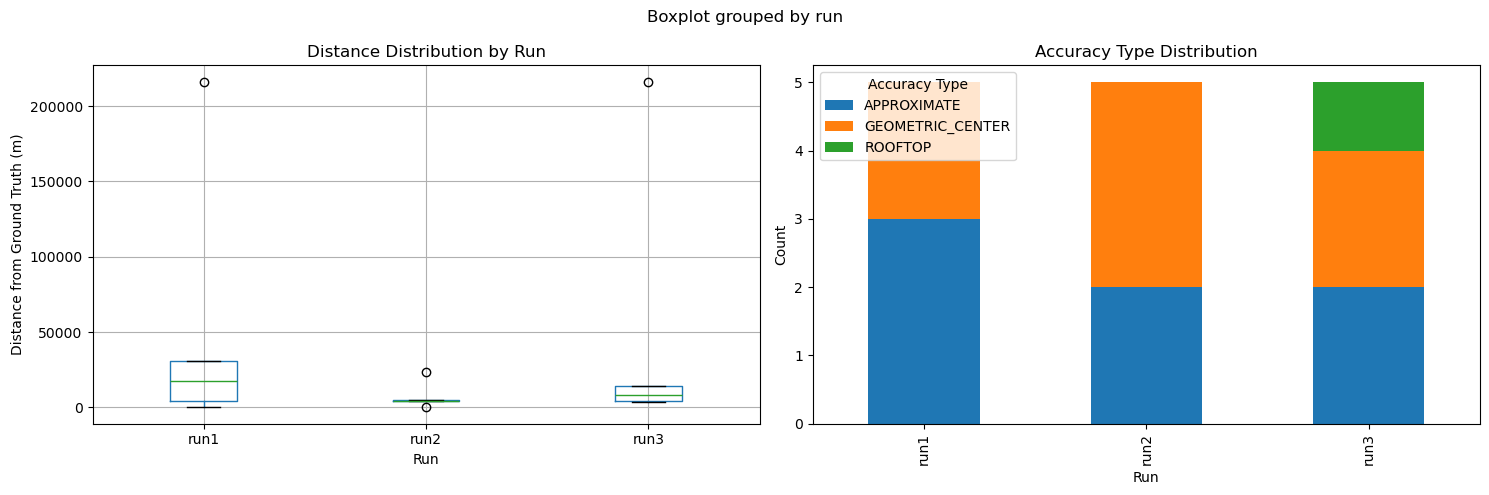

In [7]:
import matplotlib.pyplot as plt

# Plot distance comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Distance by run
results_df.boxplot(column='distance', by='run', ax=ax1)
ax1.set_xlabel('Run')
ax1.set_ylabel('Distance from Ground Truth (m)')
ax1.set_title('Distance Distribution by Run')
plt.sca(ax1)
plt.xticks(rotation=0)

# Accuracy type distribution
accuracy_counts = results_df.groupby(['run', 'accuracy']).size().unstack(fill_value=0)
accuracy_counts.plot(kind='bar', ax=ax2, stacked=True)
ax2.set_xlabel('Run')
ax2.set_ylabel('Count')
ax2.set_title('Accuracy Type Distribution')
ax2.legend(title='Accuracy Type')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

In [8]:
# Vrisko poio run einai kalytero
best_run_counts = results_df[results_df['is_best']].groupby('run').size()
print("ta kalytera runs einai:")

if len(best_run_counts) > 0:
    recommended_run = best_run_counts.idxmax()
    print(f"Best performing format: {recommended_run.upper()}")
    print(f"  - Won {best_run_counts[recommended_run]}/{len(test_results)} times")
    
    recommended_data = results_df[results_df['run'] == recommended_run]
    print(f"  - Mean distance: {recommended_data['distance'].mean():.1f}m")
    print(f"  - ROOFTOP rate: {(recommended_data['accuracy'] == 'ROOFTOP').sum()}/{len(recommended_data)}")
else:
    print("Kanena run den epityxe na briskei simeia.")

ta kalytera runs einai:
Best performing format: RUN1
  - Won 2/5 times
  - Mean distance: 53736.7m
  - ROOFTOP rate: 0/5


In [9]:
print("Testing complete!")
print(f"Tested {len(test_results)} eggrafes")
print(f"Total API calls: {len(test_results) * 3}")

Testing complete!
Tested 5 eggrafes
Total API calls: 15
